In [2]:
# Import required libraries
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from data_preprocess_utils import *
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", 
                       category=UserWarning,
                       message="pkg_resources is deprecated")

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configuration
PREPROCESS_DIR = "preprocess"  # Folder to save processed data
os.makedirs(PREPROCESS_DIR, exist_ok=True)  # Create directory if it doesn't exist

# 1. Download and load the dataset
print("Step 1: Downloading dataset...")
dataset_path = download_dataset()

if not dataset_path:
    raise Exception("Failed to download dataset. Please check your Kaggle credentials.")

print("\nStep 2: Loading dataset...")
raw_data = load_dataset(dataset_path)

if not raw_data:
    raise Exception("No MIDI files found in the dataset. Please check the dataset path.")

print(f"\nTotal MIDI files found: {len(raw_data)}")

Step 1: Downloading dataset...

Step 2: Loading dataset...
Loading MIDI files...
Loaded 3979 MIDI files

Total MIDI files found: 3979


In [4]:
# 2. Filter for selected composers
print("\nStep 3: Filtering for selected composers...")
filtered_data = filter_composers(raw_data)
print(f"Files after filtering: {len(filtered_data)}")


Step 3: Filtering for selected composers...
Files after filtering: 481



Step 4: Visualizing data distribution...


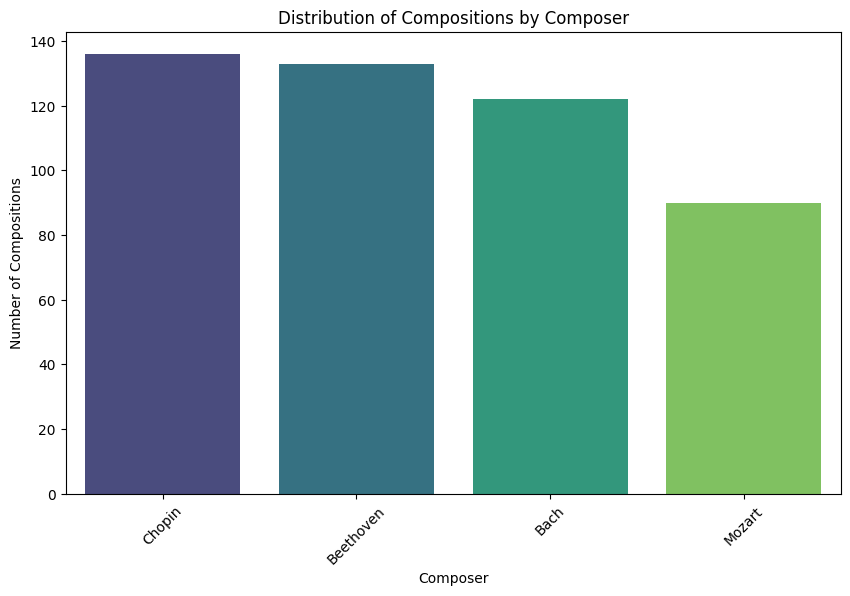

In [5]:
# 3. Visualize data distribution
print("\nStep 4: Visualizing data distribution...")
visualize_data_distribution(filtered_data)

In [6]:
# 4. Extract features from MIDI files
print("\nStep 5: Extracting features from MIDI files...")
features_data = []
error_files = []

for i, (path, composer) in enumerate(filtered_data):
    features = extract_features(path) 
    
    if features is not None:
        features_data.append((features, composer))
    else:
        error_files.append(path)

print(f"\nSuccessfully processed {len(features_data)}/{len(filtered_data)} files")


Step 5: Extracting features from MIDI files...


D:\AAI-511_Final_Project\team-11-final-project\env\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(



Successfully processed 480/481 files


In [7]:
# 5. Split dataset into train, validation, and test sets
print("\nStep 6: Splitting dataset...")
train_data, val_data, test_data = split_dataset(features_data)
print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Step 6: Splitting dataset...
Train: 336, Val: 48, Test: 96


In [8]:
# 6. Convert to PyTorch tensors
print("\nStep 7: Converting to PyTorch tensors...")
train_dataset, val_dataset, test_dataset, label_encoder = create_tensor_datasets(
    train_data, val_data, test_data
)
print("Conversion complete!")


Step 7: Converting to PyTorch tensors...
Conversion complete!



Step 8: Visualizing sample features...
Features shape: torch.Size([100, 3])
Label: Chopin


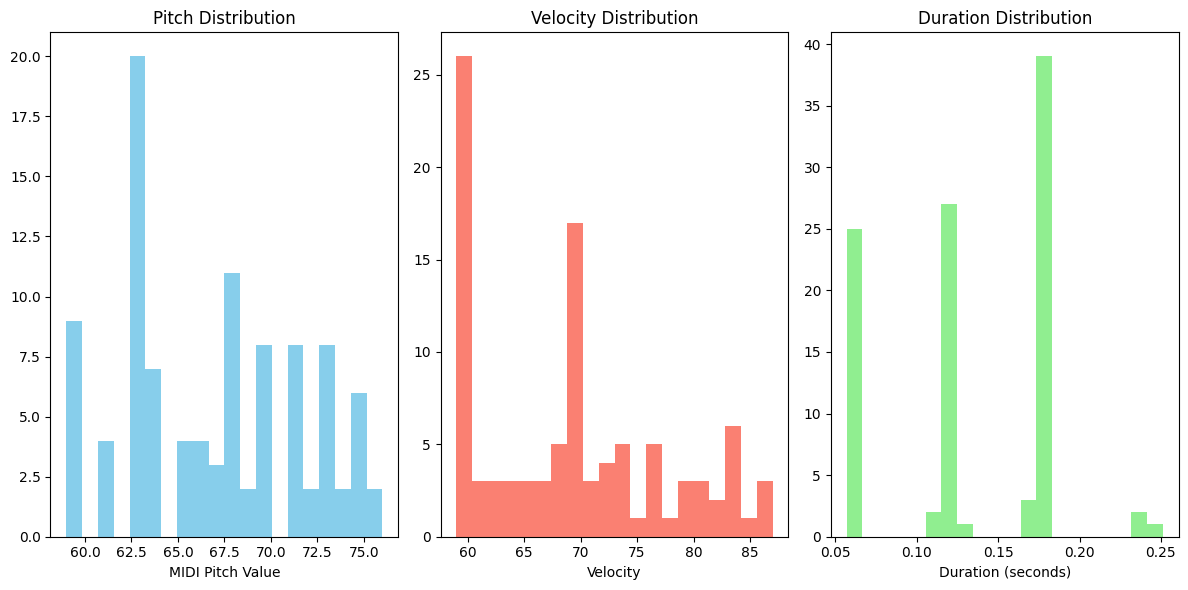

In [10]:
# 7. Visualize sample features
print("\nStep 8: Visualizing sample features...")
sample_features, sample_label = train_dataset[0]
print(f"Features shape: {sample_features.shape}")
print(f"Label: {label_encoder.inverse_transform([sample_label])[0]}")

# Plot feature distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.hist(sample_features[:, 0].numpy(), bins=20, color='skyblue')
plt.title('Pitch Distribution')
plt.xlabel('MIDI Pitch Value')

plt.subplot(1, 3, 2)
plt.hist(sample_features[:, 1].numpy(), bins=20, color='salmon')
plt.title('Velocity Distribution')
plt.xlabel('Velocity')

plt.subplot(1, 3, 3)
plt.hist(sample_features[:, 2].numpy(), bins=20, color='lightgreen')
plt.title('Duration Distribution')
plt.xlabel('Duration (seconds)')

plt.tight_layout()
plt.show()

In [11]:
# 8. Save processed data
print("\nStep 9: Saving processed data...")
# Save datasets
torch.save(train_dataset, os.path.join(PREPROCESS_DIR, 'train_dataset.pt'))
torch.save(val_dataset, os.path.join(PREPROCESS_DIR, 'val_dataset.pt'))
torch.save(test_dataset, os.path.join(PREPROCESS_DIR, 'test_dataset.pt'))

# Save label encoder
np.save(os.path.join(PREPROCESS_DIR, 'label_encoder_classes.npy'), label_encoder.classes_)

# Save error log if there were any errors
if error_files:
    with open(os.path.join(PREPROCESS_DIR, 'processing_errors.log'), 'w') as f:
        f.write("\n".join(error_files))

print(f"""Preprocessing complete! Data saved to '{PREPROCESS_DIR}' directory:
- train_dataset.pt
- val_dataset.pt
- test_dataset.pt
- label_encoder_classes.npy
- processing_errors.log (if any errors occurred)""")


Step 9: Saving processed data...
Preprocessing complete! Data saved to 'preprocess' directory:
- train_dataset.pt
- val_dataset.pt
- test_dataset.pt
- label_encoder_classes.npy
- processing_errors.log (if any errors occurred)
